In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import MCMC, NUTS, Predictive, config_enumerate
from src.data.data_loader import default_em, load_uplift
from src.data.preprocessing import (
    interval_outlier,
    detrend,
    ffnn_input_vector,
    load_thickness_time_series,
)
from src.visualization.visualize import plot_gp
from src.models.paths import PROJECT_ROOT
from src.models.pyro_custom import IntervalFoldedDistribution
from src.models.solid_earth_utils import FFNN, compute_love_numbers, greens_function

from pyro.contrib.gp.models.model import GPModel
from pyro.contrib.gp.util import conditional
from pyro.distributions.util import eye_like
import pyro.contrib.gp as gp
from pyro.nn.module import PyroParam, pyro_method

print(PROJECT_ROOT)
pyro.set_rng_seed(42)

/data/eigil/work/premis


In [2]:
def compute_error(trues, predicted):
    """
    From course material
    """
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues) ** 2))
    return corr, mae, rae, rmse

In [3]:
df_em = default_em()

lmax = 512
lmin = 0
lstep = 1
CONF = {
    "EARTH_FILE": "earth_M3L70V01c.txt",
    "COMPRESS": "1",
    "DEGREE_RANGE": f"{lmin} {lmax} {lstep}",
    "LABEL_OUTPUT": f"Bench_C_{lmax}_{lmin}_{lstep}",
}
df = load_uplift(timefreq="W")
df_tmp = df.copy()
df_tmp = df_tmp.set_index("Time")
df.Thickness = (
    interval_outlier(df_tmp, M_step=24, max_std=2)
    .Thickness.interpolate()
    .fillna(method="bfill")
    .values
)

height = detrend(df.Thickness.values)
up_kuaq = df.Up_kuaq.values
up_mik2 = df.Up_mik2.values
y_train = detrend(up_kuaq)
df_em

/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/scipy/io/matlab/_mio.py:226: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


,Nr,radius,density,rigidity,bulk,viscosity
0,1.0,6371000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+55
1,2.0,6341000.0,3037.0,5.060500e+10,5.743700e+10,1.000000e+21
2,3.0,6311000.0,3438.0,7.036300e+10,9.963300e+10,1.000000e+21
3,4.0,5951000.0,3871.0,1.054900e+11,1.535200e+11,1.000000e+21
4,5.0,5701000.0,4978.0,2.283400e+11,3.221000e+11,2.000000e+21
5,6.0,3480000.0,10750.0,0.000000e+00,1.101800e+12,0.000000e+00


## For train test split, one hot encoded month numbers are included for later use in second model

In [4]:
# For modelling seasonality at some point

# X_time = np.concatenate([pd.get_dummies(df[x]) for x in ["dow", "tod"]], axis=1)
# pd.get_dummies(df["Time"])
# Make month columns
df1 = pd.concat([df, df.Time.dt.month], axis=1)
df1.columns = [*df1.columns[:-1], "Month"]
df1.head()

# make one hot encoding of month number
month_number = np.array(pd.get_dummies(df1["Month"]))

In [5]:
centered_height = height - np.mean(height)  # / np.std(height)
X_cat = np.concatenate([centered_height[np.newaxis].T, month_number], axis=1)
X = torch.tensor(X_cat).float()

y1 = torch.tensor(detrend(up_kuaq)).float()
y1 = y1 - y1.mean()  # / y_train1.std()

y2 = torch.tensor(detrend(up_mik2)).float()
y2 = y2 - y2.mean()  # / y_train2.std()

y = torch.vstack([y1, y2]).T

In [19]:
train_perc = 0.80  # percentage of training data
split_point = int(train_perc * len(y))
# perm = np.random.permutation(len(y))
# ix_train = perm[:split_point]
# ix_test = perm[split_point:]
# X_time_train = X_time[ix_train,:]
# X_time_test = X_time[ix_test,:]
ix_train = split_point
X_train = X[:split_point, :]
X_test = X[split_point:, :]
y_train = y[:split_point]
y_test = y[split_point:]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 435
num test: 109


## load neural network to estimate love numbers

In [20]:
df_params, x = ffnn_input_vector(
    df_em, path="../data/processed/ffnn_variable_normalisation_params_512.csv"
)

ffnn = FFNN(31, 200, 513)  # in shape, n hidden, out shape
ffnn.load_state_dict(torch.load("../models/ffnn_v2.pt"))
ffnn.eval()

FFNN(
  (in_layer): Linear(in_features=31, out_features=200, bias=True)
  (h1_layer): Linear(in_features=200, out_features=200, bias=True)
  (h2_layer): Linear(in_features=200, out_features=200, bias=True)
  (out_layer): Linear(in_features=200, out_features=513, bias=True)
  (relu): ReLU()
)

## GP inference on thickness time series

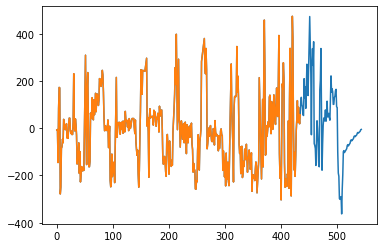

In [22]:
plt.plot(-height)
plt.plot(-X_train[:, 0])

In [33]:
y = X_train[:, 0].double()
X = torch.linspace(0, 1, len(y)).double()
# y = (y - y.mean())/y.std()

# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, variance=torch.tensor(30), lengthscale=torch.tensor(0.15), period=torch.tensor(0.1)
)
# gpr = gp.models.GPRegression(X, y, kernel, noise=torch.tensor(0.5))
Xu = torch.arange(100.0).double() / 100
gpr = gp.models.SparseGPRegression(X, y, kernel, Xu=Xu, noise=torch.tensor(20), jitter=1e-5)

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 0.8))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 0.6))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 3000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

corr = -0.6001785698907609, 
mae = 60.68757765558098, 
rae = 1.0365290344004523, 
rmse = 79.06501147542902
corr = -0.31773549479520896, 
mae = 113.40579862724535, 
rae = 1.0183021527393243, 
rmse = 147.49476472664102


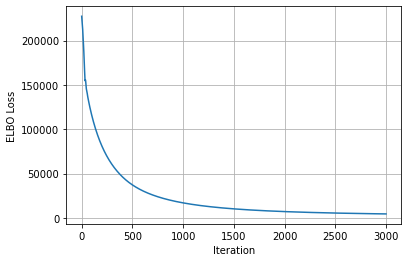

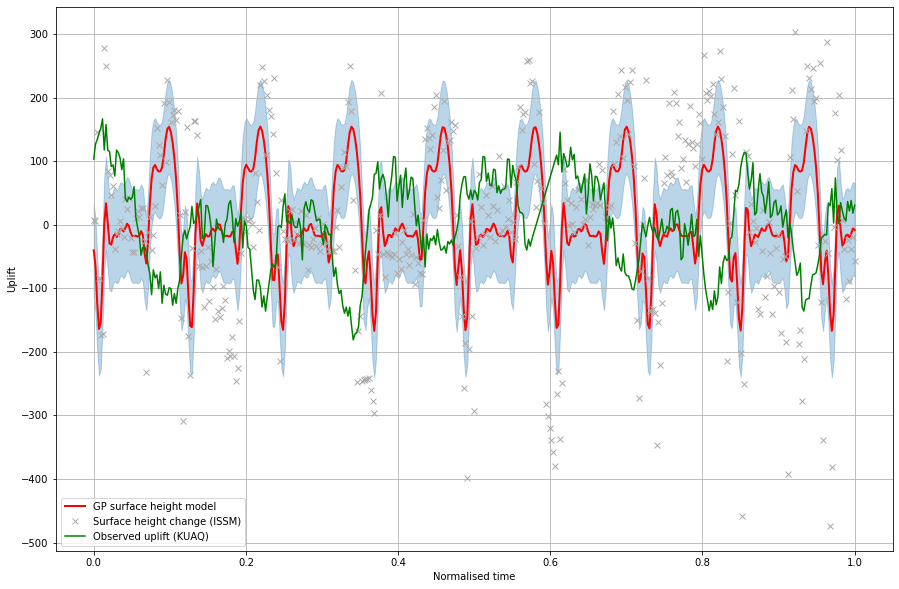

In [34]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("ELBO Loss")
plt.grid()
plt.savefig("./GP_loss.png", dpi=400)

plt.figure(figsize=(15, 10))
ax = plt.gca()
uplift = y_train[:, 0].numpy()
X_test = torch.linspace(0, 1, len(uplift)).double()  # test inputs
# plot(X_test, model=gpr, plot_observed_data=True, plot_predictions=True, limits=[0, 1])
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
sd = cov.diag().sqrt()  # standard deviation at each input point x

with torch.no_grad():
    ax.plot(X_test.numpy(), mean.numpy(), "r", lw=2, label="GP surface height model")  # plot the mean
    ax.fill_between(
        X_test.numpy(),  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd).numpy(),
        (mean + 2.0 * sd).numpy(),
        color="C0",
        alpha=0.3,
    )

plt.plot(X_test, y, linestyle="None", marker="x", label="Surface height change (ISSM)", color="darkgrey")
plt.plot(X_test, 10 * uplift, label="Observed uplift (KUAQ)", color="green")
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend()
plt.savefig("./GP_spregression.png", dpi=400)

preds = gpr(X_test, full_cov=True)[0].detach()
corr, mae, rae, rmse = compute_error(preds.numpy(), uplift)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")
corr, mae, rae, rmse = compute_error(y.numpy(), uplift) # (upl - np.mean(upl)) / np.std(upl)
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

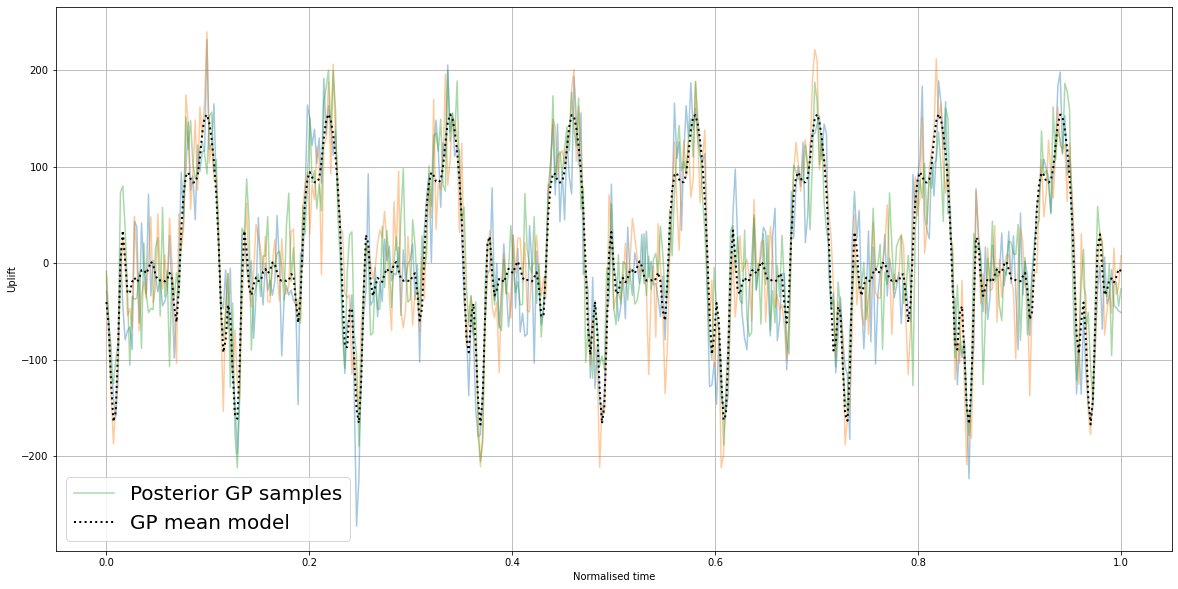

In [39]:
plt.figure(figsize=(20,10))
mean, cov = gpr(X_test, full_cov=True, noiseless=False)
for i in range(2):
    with torch.no_grad():
        sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
        plt.plot(X_test, sample, alpha=0.4)
        
sample = pyro.sample("test", dist.MultivariateNormal(mean, cov))
plt.plot(X_test, sample.detach(), alpha=0.4, label="Posterior GP samples")
plt.plot(X_test, mean.detach(), "black", lw=2, linestyle=":", label="GP mean model", alpha=1)
plt.xlabel("Normalised time")
plt.ylabel("Uplift")
plt.grid()
plt.legend(fontsize=20)
plt.savefig("./GP_posterior_samples.png", dpi=400)


In [49]:
mean, cov = gpr(X_test, full_cov=True, noiseless=False)

In [58]:
def model(X, x, df_params, mean_v=None, cov_v=None, obs=None, df_em=None):
    N = len(X)
    K = 2
    seasonality = 12 # months
    
    # seasonality modelling
    alpha_s = pyro.sample("alpha_s", dist.Normal(0., 1.))
    sigma_s = pyro.sample("sigma_s", dist.Normal(torch.zeros(seasonality, 2), torch.ones(seasonality, 2)))

    rigidity_1 = pyro.sample("rigidity_1", dist.LogNormal(24.12 * torch.ones(1), 0.5))
    rigidity_2 = pyro.sample("rigidity_2", dist.LogNormal(24.4 * torch.ones(1), 0.5))

    x[14] = (rigidity_1 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]
    x[15] = (rigidity_2 - df_params["rigidity_mu"][0]) / df_params["rigidity_sigma"][0]

    hlove = ffnn(x).detach().numpy()
    nlove = len(hlove)

    # Draw Greens Function
    gf_kuaq = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.58700000, -33.05270000],
        arsurf=80e3 * 80e3,
    )
    gf_mik2 = greens_function(
        hlove,
        nlove,
        [68.704665, -33.214577],
        [68.14029705, -31.45179999],
        arsurf=80e3 * 80e3,
    )

    gf = pyro.deterministic("gf", 5e1 * torch.tensor([gf_kuaq, gf_mik2]))
    
    with pyro.plate("time", N):
        dh = pyro.sample("dh", dist.MultivariateNormal(mean_v.float(), cov_v.float()))
    
    # Draw target
    with pyro.plate("data", K):
        w = pyro.sample(
            "w", dist.Normal(gf * dh[..., None], torch.exp(alpha_s + X[:, 1:].matmul(sigma_s))), obs=obs
        )
    return w

In [59]:
# import os
# os.environ["OMP_NUM_THREADS"] = '1'
# Run inference in Pyro

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=100, num_chains=1)
# mcmc.run(X_train, x, df_params, y_train, df_em)
mcmc.run(X_train, x, df_params, mean_v=mean, cov_v=cov, obs=y_train, df_em=df_em)

Warmup:   5%|▍         | 54/1100 [09:20, 11.23s/it, step size=1.41e-03, acc. prob=0.812]

In [ ]:
# Show summary of inference results
mcmc.summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha_s      1.80      0.19      1.79      1.52      2.13     25.61      1.00
rigidity_1[0] 33658433536.00 18787678208.00 29762191360.00 8094905856.00 57869262848.00   1091.39      1.00
rigidity_2[0] 44440014848.00 24018288640.00 39415189504.00 14246647808.00 80969023488.00   1181.11      1.00
 sigma_s[0,0]     -0.16      0.22     -0.17     -0.49      0.22     32.44      1.00
 sigma_s[0,1]     -0.27      0.21     -0.27     -0.59      0.10     34.27      1.00
 sigma_s[1,0]     -0.17      0.23     -0.17     -0.56      0.18     39.20      1.00
 sigma_s[1,1]     -0.33      0.22     -0.34     -0.72      0.00     34.89      1.00
 sigma_s[2,0]      0.20      0.22      0.21     -0.19      0.52     34.98      1.00
 sigma_s[2,1]     -0.17      0.22     -0.17     -0.53      0.19     34.57      1.01
 sigma_s[3,0]      0.27      0.22      0.28     -0.12      0.60     37.21      1.00
 sigma_s[3,1]      0.06   

In [ ]:
#### compare to PREM
# from table IV
depths = abs(df_em["radius"].values - df_em.loc[0, "radius"]) / 1e3  # in km
depth_table = np.array([0, 3, 15, 24, 40, 60, 80])
A = np.array([21, 875, 1341, 2268, 2260, 2251, 2242])
C = np.array([21, 875, 1341, 2176, 2165, 2151, 2138])
L = np.array([0, 266, 441, 653, 654, 655, 656])
N = np.array([0, 266, 441, 719, 714, 708, 702])
F = np.array([21, 342, 459, 866, 863, 860, 857])

prem_rigidity_0 = np.mean(1 / 15 * (A[0] + C[0] - 2 * F[0] + 5 * N[0] + 6 * L[0]))
prem_rigidity_1 = np.mean(1 / 15 * (A[:4] + C[:4] - 2 * F[:4] + 5 * N[:4] + 6 * L[:4]))
prem_rigidity_2 = np.mean(
    1 / 15 * (A[4:6] + C[4:6] - 2 * F[4:6] + 5 * N[4:6] + 6 * L[4:6])
)
prem_rigidity = {
    "rigidity_0": prem_rigidity_0 * 1e8,
    "rigidity_1": prem_rigidity_1 * 1e8,
    "rigidity_2": prem_rigidity_2 * 1e8,
}

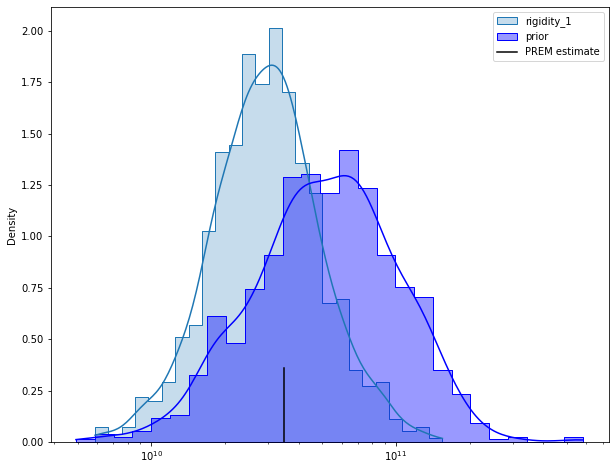

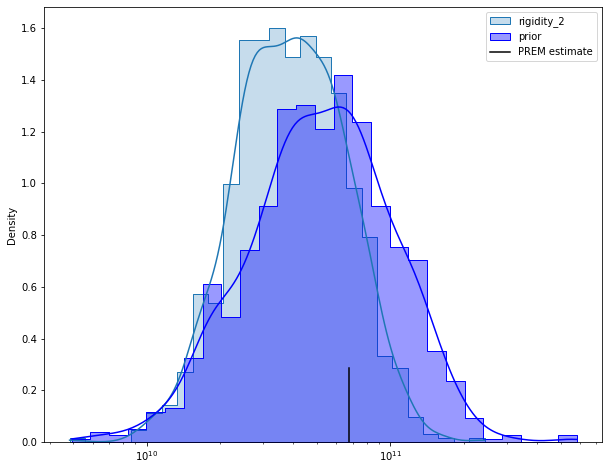

In [ ]:
samples = {k: v for k, v in mcmc.get_samples().items()}
nodes = ["rigidity_1", "rigidity_2"]


# rigidity_dist_prior = dist.Normal(2 * torch.ones(1000), 0.2)
# rigidity_prior = 1e11 + 1e10 * pyro.sample("rigidity_prior", rigidity_dist_prior)
# rigidity_prior = 1e11 * pyro.sample("rigidity_prior", dist.Exponential(torch.ones(2000)))
rigidity_prior = pyro.sample(
    "rigidity_prior", dist.LogNormal(logmean * torch.ones(1000), 0.7)
)
for node in nodes:
    plt.figure(figsize=(10, 8))
    g = sns.histplot(
        # 1e11 + 1e10 * samples[node],
        samples[node],
        label=node,
        kde=True,
        stat="density",
        element="step",
        color="red",
        log_scale=True,
    )
    sns.histplot(
        rigidity_prior,
        label="prior",
        kde=True,
        stat="density",
        element="step",
        alpha=0.4,
        color="blue",
        log_scale=True,
    )
    plt.axvline(prem_rigidity[node], 0, 0.17, color="black", label="PREM estimate")
    plt.legend()
    plt.savefig("./ch3_{}_dist.png".format(node), dpi=400)
    plt.show()
    

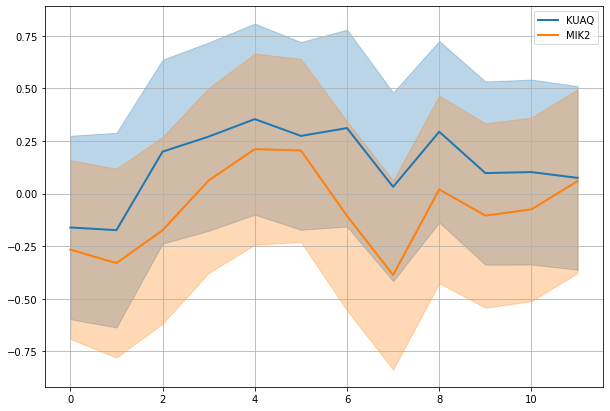

In [ ]:
sigma_s_mu = samples["sigma_s"].mean(axis=0)
sigma_s_std =samples["sigma_s"].std(axis=0)

plt.figure(figsize=(10,7))
plt.plot(sigma_s_mu[:, 0], lw=2, label="KUAQ")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 0] - 2.0 * sigma_s_std[:, 0]).numpy(),
            (sigma_s_mu[:, 0] + 2.0 * sigma_s_std[:, 0]).numpy(),
            color="C0",
            alpha=0.3,
        )
plt.plot(sigma_s_mu[:, 1], lw=2, label="MIK2")
plt.fill_between(
            range(12),  # plot the two-sigma uncertainty about the mean
            (sigma_s_mu[:, 1] - 2.0 * sigma_s_std[:, 1]).numpy(),
            (sigma_s_mu[:, 1] + 2.0 * sigma_s_std[:, 1]).numpy(),
            color="C1",
            alpha=0.3,
        )
plt.legend()
plt.grid()
plt.savefig("./ch3_seasonality_sigma_s.png", dpi=400)

(2000,)


/data/eigil/miniconda3/envs/premis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


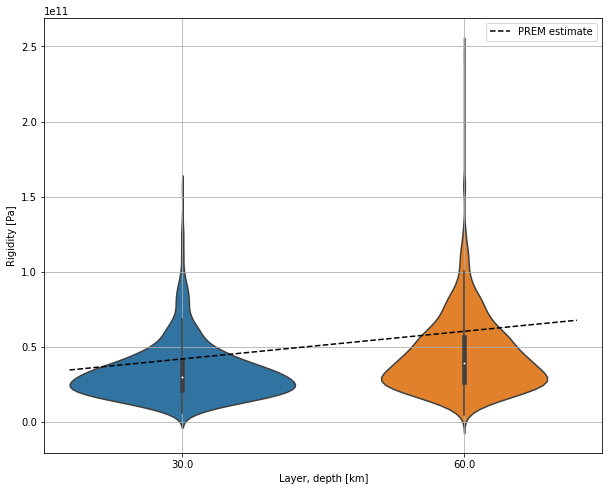

In [ ]:
rigidity_list = []
prem_rigidity_list = [prem_rigidity["rigidity_0"]]
for node in nodes:
    rigidity_list.append(samples[node].numpy())
    prem_rigidity_list.append(prem_rigidity[node])
    
layers = np.hstack((30 * np.ones(1000), 60 * np.ones(1000)))
print(layers.shape)
df_layers = pd.DataFrame(np.array([np.vstack(rigidity_list).squeeze(), layers]).T, 
                         columns=["Rigidity [Pa]", "Layer, depth [km]"])

plt.figure(figsize=(10,8))
sns.violinplot(x = "Layer, depth [km]", y = "Rigidity [Pa]", data = df_layers)
sns.lineplot([-0.4, 1.4], prem_rigidity_list[1:], color="black", linestyle="--", label="PREM estimate")
plt.grid('minor')
plt.savefig("ch3_violin.png", dpi=400)

### Compare to observations

In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, samples)(X_train, x, df_params, None, df_em)
for k, v in predictive.items():
    print(f"{k}: {tuple(v.shape)}")

w: (1000, 435, 2)
gf: (1000, 1, 2)


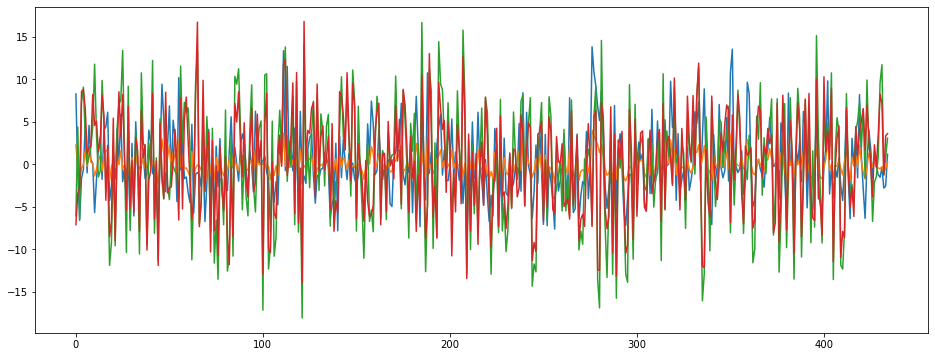

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["w"].mean(axis=0))
plt.plot(y_train[:, 0])
plt.plot(y_train[:, 1])

In [ ]:
predictive["gf"].mean(axis=0)

tensor([[-0.0264, -0.0075]])

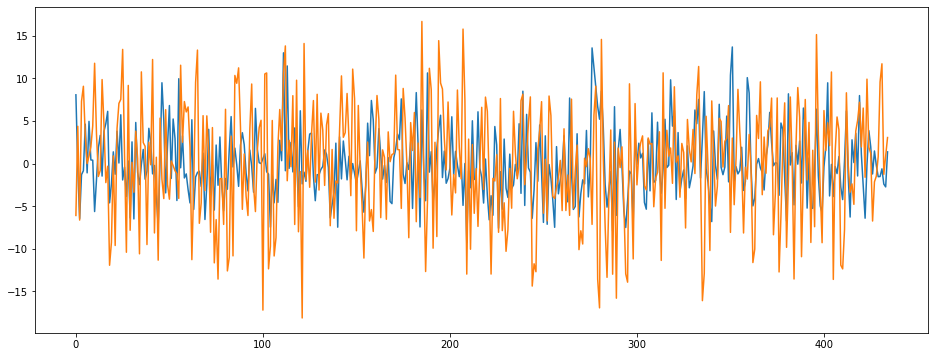

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(predictive["gf"].mean(axis=0)[0, 0] * X_train[:,0])
plt.plot(y_train[:, 0])

In [ ]:
posterior_samples = mcmc.get_samples()

In [ ]:
predictive["gf"].mean(axis=0).shape

torch.Size([1, 2])

In [ ]:
y_hat = predictive["gf"].mean(axis=0) * X_test[:,0].reshape(109,1)

In [ ]:
y_hat.shape

torch.Size([109, 2])

In [ ]:
corr, mae, rae, rmse = compute_error(y_test.numpy(), y_hat.numpy())
print("CorrCoef: %.3f\nMAE: %.3f\nRAE: %.3f\nRMSE: %.3f" % (corr, mae, rae, rmse))

CorrCoef: -1.000
MAE: 4.880
RAE: 0.928
RMSE: 5.985


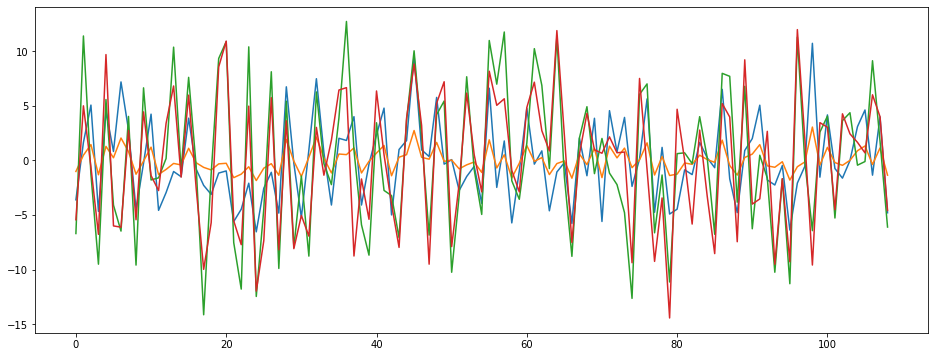

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(y_hat)
plt.plot(y_test)

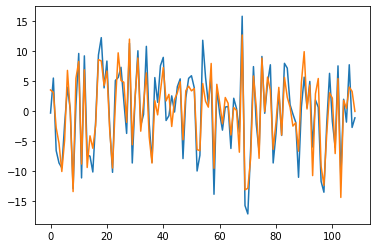

In [ ]:
plt.plot(y_test)

In [34]:
w_pred = (-gf_res * X_train[:, 0]).mean(axis=0)
plt.plot(y_train)
plt.plot(w_pred)
corr, mae, rae, rmse = compute_error(y_train.numpy(), w_pred.numpy())
print(f"corr = {corr}, \nmae = {mae}, \nrae = {rae}, \nrmse = {rmse}")

NameError: name 'gf_res' is not defined